<a href="https://colab.research.google.com/github/jboehm1/VisualOdometry/blob/master/VO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Odometry
 Construct list of random index **k** and **k+s** where **s** is the stride < **max_stride** (used for image and R T training)

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0
%load_ext tensorboard


     |████████████████████████████████| 332.1MB 136kB/s 
     |████████████████████████████████| 3.0MB 27.0MB/s 
     |████████████████████████████████| 419kB 42.6MB/s 


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
device=tf.test.gpu_device_name()
device

'/device:GPU:0'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loading

In [0]:
import numpy as np
import random
import cv2
import math
import datetime 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.keras import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, Flatten, Dense, Concatenate,Input, MaxPooling2D,BatchNormalization, Activation, GlobalAveragePooling2D
# example of saving an image with the Keras API
from keras.preprocessing.image import load_img
from keras.preprocessing.image import save_img
from keras.preprocessing.image import img_to_array

# https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403
import h5py
from PIL import Image

path = "/content/drive/My Drive/Colab Notebooks/VO/"
liste_folder = ['00','01','02','03','04']

# num_poses = 2000 #TO DO : deal with end of liste
# num_folder=1
# # for folder in list_folders:
# liste=[[k, k+random.randint(1,max_stride)] for k in range((num_poses)) ]

# #Shuffle list !
# np.random.shuffle(liste)

In [0]:
# fileName = path+'x_train_all.h5'
# with h5py.File(fileName, "w") as out:
#   for k in range len(num_folder):
#     out.create_dataset("x_train_"+k, np.shape(x_train) )
#     out.create_dataset("R_train_"+k, np.shape(  ) )
#     out.create_dataset("T_train_"+k, np.shape(  ) )


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [0]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

In [0]:
# load data, to do : print number of loads / total 
def load_data(train_or_test):
  if train_or_test == 'train':
    data =  [[ np.dstack( (cv2.imread(path+'image_0/{:06}.png'.format(k*2), 0),
                                       cv2.imread(path+'image_0/{:06}.png'.format(l), 0) ) ) ] for k,l in index_train]
  if train_or_test == 'test':
    data =  [[ np.dstack( (cv2.imread(path+'image_0/{:06}.png'.format(k*2), 0),
                                       cv2.imread(path+'image_0/{:06}.png'.format(l), 0) ) ) ] for k,l in index_test]                            
  return data

In [0]:
# load data, to do : print number of loads / total 
from tqdm import tqdm
def load_data_disp(train_or_test):
  data=[]
  length0 = len(eval("index_"+train_or_test) )
  pbar = tqdm(total=length0)
  mem=0

  for k,l in eval("index_"+train_or_test):
    try:
      data.append ( [ np.dstack( (cv2.imread(path+'image_0/{:06}.png'.format(k*2), 0),
                                      cv2.imread(path+'image_0/{:06}.png'.format(l*2), 0) ) ) ]  )
      if k%100==0:
        
        # printProgressBar(k, length0, prefix = 'Progress:', suffix = 'Complete', length = 50)
        pbar.update(100)
        pass
    except:
      print (k)
      mem=mem+1
  
  print(train_or_test+"dataset loaded successfully yeah")
  pbar.close()
  return data

In [0]:
# load data, to do : print number of loads / total 
from tqdm import tqdm
def load_data_folder(folder, liste):
  data=[]
  # liste=index_list_list[int(folder[1])]

  length0 = len(liste)
  pbar = tqdm(total=length0)
  mem=0

  for k,l in liste:
    try:
      data.append ( [ np.dstack( ( img_to_array( load_img(path+folder+'/image_0/{:06}.png'.format(k), color_mode='grayscale', target_size = (188,620) ) ) / 255,
                                       img_to_array (load_img(path+folder+'/image_0/{:06}.png'.format(l), color_mode = 'grayscale', target_size = (188,620)  ) )/255 ) ) ]  )
      if k%100==0:
        
        # printProgressBar(k, length0, prefix = 'Progress:', suffix = 'Complete', length = 50)
        pbar.update(100)
        pass
    except:
      print(k)
      print("________!!!!!!!!!!!!!!!!!!!!!!!!!!_________")
      mem=mem+1
      break
  print(folder+"dataset loaded successfully yeah")
  pbar.close()
  
  return np.reshape(data, (len(data), 188,620,2 ) )

In [0]:
# load data, to do : print number of loads / total 
from tqdm import tqdm
def load_data_folder_1(folder, liste):
  data=[]
  # liste=index_list_list[int(folder[1])]

  length0 = len(liste)
  pbar = tqdm(total=length0)
  mem=0

  [[cv2.imread(path+folder+'/image_0/{:06}.png'.format(k), 0) , cv2.imread(path+folder+'/image_0/{:06}.png'.format(k), 0)] for k,l in liste]


  # for k,l in liste:
  #   try:
  #     img1=cv2.imread(path+folder+'/image_0/{:06}.png'.format(k), 0)
  #     img2=cv2.imread(path+folder+'/image_0/{:06}.png'.format(l), 0)
  #     # img1 = load_img(path+folder+'/image_0/{:06}.png'.format(k), color_mode='grayscale', target_size = (188,620) )
  #     # img2 = load_img(path+folder+'/image_0/{:06}.png'.format(l), color_mode = 'grayscale', target_size = (188,620)  )
  #     data.append ( [ np.dstack( ( img_to_array( img1 )/255 ,
  #                                      img_to_array ( img2 ) / 255 ) ) ]  )
      
  #     if k%100==0:
        
  #       # printProgressBar(k, length0, prefix = 'Progress:', suffix = 'Complete', length = 50)
  #       pbar.update(100)
  #       pass
  #   except:
  #     print(k)
  #     print("________!!!!!!!!!!!!!!!!!!!!!!!!!!_________")
  #     mem=mem+1
  #     break
  print(folder+"dataset loaded successfully yeah")
  pbar.close()
  
  return np.reshape(data, (len(data), 188,620,2 ) )

In [0]:
img1=np.load( (path+'00'+'/image_0/{:06}.png'.format(10) ))


ValueError: ignored

In [0]:
np.shape(img1)

(376, 1241)

In [0]:
if 'x_train_0' in globals():
  if len(liste)!=len(x_train_0):
    print("Data changed")
    print("\n Loading data ...")
    x_test_dstacked=[]
    x_train_dstacked=[]
    # x_train_dstacked = load_data_disp('train')
    x_train_0 = load_data_folder('00')
    x_train_1 = load_data_folder('11')


    print("Data loaded, training data shape = {}".format(np.shape(x_train_0) ))
  else:
    print("Data already loaded, training data shape = {}".format(np.shape(x_train_0) ))
else:
  print("\n Loading data ...")
  # x_train_dstacked =  load_data_disp('train')
  x_train_0 =  load_data_folder('00')
  x_train_1 = load_data_folder('11')
  # x_test_dstacked = load_data_disp('test')

  print("Data loaded, training data shape = {}".format(np.shape(x_train_0) ))



  0%|          | 0/2000 [00:00<?, ?it/s]

Data changed

 Loading data ...


100%|██████████| 2000/2000 [00:29<00:00, 85.79it/s]

image_0dataset loaded successfully yeah


Data loaded, training data shape = (2000, 1, 188, 620, 2)


In [0]:
fileName = path+'x_train_image1.h5'
with h5py.File(fileName, "w") as out:
  out.create_dataset("x_train", np.shape(x_train) )

In [0]:
with h5py.File(fileName, "a") as out:
  out['x_train'] = x_train_image1

In [0]:
file =h5py.File(path+'x_train_image1.h5', 'r')
x_train0 = file['x_train']
list(file.keys())

['x_train']

In [0]:
# del x_train_dstacked

In [0]:
np.shape(x_train_dstacked)
#  stacked=np.dstack(( cv2.imread(path+'/image_0_cropped/{:06}.png'.format(0), 0), cv2.imread(path+'/image_0_cropped/{:06}.png'.format(1), 0) ) )

NameError: ignored

In [0]:
# resh=np.reshape(x_train_dstacked[0], (376,1241,2))

In [0]:
x=[(1,2),(3,4)]

In [0]:
plt.imshow(x_train[0][0])

NameError: ignored

In [0]:
x[:][1]

# create r t data_full

In [0]:
# img1 = tf.io.read_file(path+'/000000.png') # Try out with TF !!!!
def create_R_T(folder):
  file='/content/drive/My Drive/Colab Notebooks/VO/poses/'+folder+'.txt'
  with open(file,'r') as file:
    out=[line.split() for line in file]


  out_liste = np.array( [ np.array([float(item) for item in k]) for k in out[:-1] ] ) #remove last element which is empty
  # liste_R = out_liste[:,3:] #:-3
  print("out_liste length = "+str( np.shape(out) ))
  # Create Translation vector 
  liste_T = np.array( [[a[3], a[7], a[11]] for a in out_liste] )


  global liste_R_simple


  liste_index= [0,1,2,4,5,6,8,9,10]
  liste_R_simple = [out_liste[k][liste_index] for k in range(len(out_liste)) ]  


  # Create Rotation vector
  x_liste=[]
  z_liste=[]
  y_liste=[]
  liste_R = []
  liste_R_degree = []
  global liste_quat
  liste_quat = np.array( [ quatFromRotMatx(R) for R in liste_R_simple] )


  for k in range(len(out_liste)):
    R=out_liste[k]
    sy = math.sqrt(R[0] * R[0] +  R[4] * R[4])

    x = math.atan2(R[9] , R[10])
    y = math.atan2(-R[8], sy)
    z = math.atan2(R[4], R[0])
    liste_R_degree.append([180*x/math.pi, 180*y/math.pi, 180*z/math.pi])
    liste_R.append([x, y, z])
    # print(180*x/math.pi,180*y/math.pi,180*z/math.pi)
    x_liste.append(180*x/math.pi)
    z_liste.append(z)
    y_liste.append(y)


  # Conversion to numpy arry, to be checked 
  liste_R = np.array(liste_R)
  liste_R_degree = np.array(liste_R_degree)
 
  # Stride between images from 1 to max_stride (kitti=10fps)
  max_stride=10

  
  # each folder has its own seed 
  random.seed(int(folder[1]))

  # Create liste of combination
  liste=[[k, k+random.randint(1,max_stride)] for k in range( len(out_liste) -max_stride) ]

  #Shuffle it !!
  random.shuffle(liste)

  # Extract the difference between index
  T_train = [ liste_T[b] - liste_T[a] for a, b in liste]
  # R_train = [ liste_R[b] - liste_R[a] for a, b in liste]
  # R_train = [ liste_R_simple[b] - liste_R_simple[a] for a, b in liste]
  R_train = [ liste_quat[b] - liste_quat[a] for a, b in liste]

# 
  return R_train, T_train, liste

In [0]:
def quatFromRotMatx(R):
    """Get a quaternion from a given rotation matrix `R`."""
    # https://xy-python-utils.readthedocs.io/en/latest/_modules/quaternion.html
    q = np.zeros(4)

    q[0] = ( R[0] + R[4] + R[8] + 1) / 4.0
    q[1] = ( R[0] - R[4] - R[8] + 1) / 4.0
    q[2] = (-R[0] + R[4] - R[8] + 1) / 4.0
    q[3] = (-R[0] - R[4] + R[8] + 1) / 4.0

    
    # q[0] = ( R[0,0] + R[1,1] + R[2,2] + 1) / 4.0
    # q[1] = ( R[0,0] - R[1,1] - R[2,2] + 1) / 4.0
    # q[2] = (-R[0,0] + R[1,1] - R[2,2] + 1) / 4.0
    # q[3] = (-R[0,0] - R[1,1] + R[2,2] + 1) / 4.0

    q[q<0] = 0   # Avoid complex number by numerical error.
    q = np.sqrt(q)

    q[1] *= np.sign(R[7] - R[5])
    q[2] *= np.sign(R[2] - R[6])
    q[3] *= np.sign(R[3] - R[1])
    
    # q[1] *= np.sign(R[2,1] - R[1,2])
    # q[2] *= np.sign(R[0,2] - R[2,0])
    # q[3] *= np.sign(R[1,0] - R[0,1])

    return q

In [0]:
def quatToRotMatx(q, reshaped=False):
    """Get a rotation matrix from the given unit quaternion `q`."""
    R = np.zeros((3,3))

    R[0,0] = 1 - 2*(q[2]**2 + q[3]**2)
    R[1,1] = 1 - 2*(q[1]**2 + q[3]**2)
    R[2,2] = 1 - 2*(q[1]**2 + q[2]**2)

    R[0,1] = 2 * (q[1]*q[2] - q[0]*q[3])
    R[1,0] = 2 * (q[1]*q[2] + q[0]*q[3])

    R[0,2] = 2 * (q[1]*q[3] + q[0]*q[2])
    R[2,0] = 2 * (q[1]*q[3] - q[0]*q[2])

    R[1,2] = 2 * (q[2]*q[3] - q[0]*q[1])
    R[2,1] = 2 * (q[2]*q[3] + q[0]*q[1])

    if reshaped:
      R = np.reshape(R, (1,9))

    return R

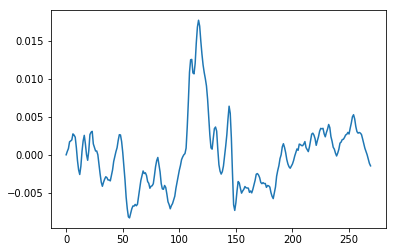

In [0]:
plt.plot(liste_quat[:,3])

In [0]:
q

array([1., 0., 0., 0.])

In [0]:
# with tf.device('/gpu:0'):
  R_liste=[]
  T_liste=[]
  index_list_list=[]
  for item in liste_folder:
    print(item)
    R, T, index_list=create_R_T(item)
    R_liste.append(R)
    T_liste.append(T)
    print("Data from folder "+item+" loaded \n")
    print("_________________")
    

00
out_liste length = (4541, 12)
Data from folder 00 loaded 

_________________
01
out_liste length = (1101, 12)
Data from folder 01 loaded 

_________________
02
out_liste length = (4661, 12)
Data from folder 02 loaded 

_________________
03
out_liste length = (801, 12)
Data from folder 03 loaded 

_________________
04
out_liste length = (271, 12)
Data from folder 04 loaded 

_________________


In [0]:
# # with tf.device('/gpu:0'):
#   R_liste=[]
#   T_liste=[]
#   index_list_list=[]
#   data=[]
#   for item in liste_folder:
#     print(item)
#     R, T, index_list=create_R_T(item)
#     R_liste.append(R)
#     T_liste.append(T)
#     index_list_list.append(index_list)
#     data_loc=load_data_folder(item, index_list)
#     data.append(data_loc)
#     print("Data from folder "+item+" loaded \n")
#     np.save(path+'data'+str(item[1]), data_loc)
#     print("_________________")
    

In [0]:
 for item in liste_folder[1:2]:
    print(item)

01


In [0]:
import numpy as np:

0
1
2
3
4


In [0]:
data_full=[]
for k in range(0,5):
  data_full.append( np.load(path+'data'+str(k)+'.npy') )
  print(k)

In [0]:
np.shape(data_full[0])

(4530, 188, 620, 2)

In [0]:
np.shape(data[1])

(4650, 188, 620, 2)

In [0]:
full_data =np.concatenate(( data[0],data[1], data[2], data[3] ) , axis=0)

In [0]:
np.shape(R_liste)

(5,)

In [0]:
# full_liste_R = np.concatenate( (R_liste[0], R_liste[1], R_liste[2],R_liste[3], R_liste[4]) , axis=0 )
# full_liste_T = np.concatenate( (T_liste[0], T_liste[1], T_liste[2],T_liste[3], T_liste[4]), axis=0 )


In [0]:
# np.save(path+'full_liste_R_[y]', full_liste_R)
# np.save(path+'full_liste_T', full_liste_T)


In [0]:
full_liste_R=np.concatenate()

In [0]:
np.shape(Output)

NameError: ignored

In [0]:
nfile='/content/drive/My Drive/Colab Notebooks/VO/poses/'+'01'+'.txt'
with open(file,'r') as file:
  out=[line.split() for line in file]


In [0]:

np.shape(out)

NameError: ignored

In [0]:
np.save(path+'data_0-4', data)

# Network architecture
With "decoupeled" (from "UnDeepVO") output to deal with high non linearity of 
Rotation matrix (using layers.concatenate)

TO TRY:
* only one output vector, and add weight per hand 
* divide image: foreground better for translation, background for rotation

In [0]:
def create_vgg(): # to do : loops to create layers
  input_shape = Input( (188, 620, 2) )

  conv1 = (Conv2D(filters=64, kernel_size=3,  
                  padding='valid', activation='relu', name='conv1' ))(input_shape)
  conv2 = (Conv2D(64, 3,  activation='relu',name='conv2'))(conv1)
  pooling1 = MaxPooling2D(2,name='pooling1')(conv2)

  conv3 = (Conv2D(128, 3,  activation='relu',name='conv3'))(pooling1)
  conv4 = (Conv2D(128, 3, activation='relu',name='conv4'))(conv3)
  pooling2 = MaxPooling2D(2,name='pooling2')(conv4)

  conv5 = (Conv2D(256, 3,  activation='relu',name='conv5'))(pooling2)
  conv6 = (Conv2D(256, 3,  activation='relu',name='conv6'))(conv5)
  conv7 = (Conv2D(256, 3,  activation='relu',name='conv7'))(conv6)
  pooling3 = MaxPooling2D(2,name='pooling3')(conv7)

  conv8 = (Conv2D(512, 3,  activation='relu',name='conv8'))(pooling3)
  conv9 = (Conv2D(512, 3,  activation='relu',name='conv9'))(conv8)
  conv10 = (Conv2D(512, 3,  activation='relu',name='conv10'))(conv9)
  pooling4 = MaxPooling2D(2,name='pooling4')(conv10)

  # conv11 = (Conv2D(512, 3,  activation='relu',name='conv11'))(pooling4)
  # conv12 = (Conv2D(512, 3,  activation='relu',name='conv12'))(conv11)
  # conv13 = (Conv2D(512, 3,  activation='relu',name='conv13'))(conv12)
  # pooling5 = MaxPooling2D(4,name='pooling5')(conv13)

  flatten1 = Flatten(name='flatten')(pooling4)
  dense1 = Dense(512, activation='relu',name='dense1')(flatten1)
  # dense2 = Dense(1024, activation = 'relu',name='dense2')(dense1)
  T_network = Dense(3 , name='T')(dense1)
  R_network = Dense(9 , name='R')(dense1)

  
  model = Model(input_shape, [T_network, R_network])
  model.compile(loss='mean_squared_error', optimizer='adam', 
                metrics=['accuracy'])

  return model

In [0]:
def create_pooling():
  input_shape = Input( ( 188, 620, 2) )

  conv1 = (Conv2D(filters=64, kernel_size=3,  
                  padding='valid', activation='relu', name='conv1' ))(input_shape)
  pooling1 = MaxPooling2D(2,name='pooling1')(conv1)

  conv2 = (Conv2D(128, 3,  activation='relu',name='conv3'))(pooling1)
  pooling2 = MaxPooling2D(2,name='pooling2')(conv2)

  conv3 = (Conv2D(256, 3,  activation='relu',name='conv5'))(pooling2)
  pooling3 = MaxPooling2D(2,name='pooling3')(conv3)

  conv4 = (Conv2D(512, 3,  activation='relu',name='conv10'))(pooling3)
  pooling4 = MaxPooling2D(2,name='pooling4')(conv4)

  conv5 = (Conv2D(512, 3,  activation='relu',name='conv13'))(pooling4)
  # pooling5 = MaxPooling2D(2,name='pooling5')(conv5)

  # flatten1 = Flatten(name='flatten')(pooling5)
  # dense1 = Dense(512, activation='relu',name='dense1')(flatten1)

  conv6 = (Conv2D(512, 3,  activation='relu',name='conv6'))(conv5)
  conv7 = (Conv2D(512, 3,  activation='relu',name='conv7'))(conv5)

  flattenT = Flatten()(conv6)
  flattenR = Flatten()(conv7)
  T_network = Dense(3 , name='T')(flattenT)
  R_network = Dense(9 , name='R')(flattenR)

  
  model = Model(input_shape, [T_network, R_network])
  model.compile(loss='mean_squared_error', optimizer='adam', 
                metrics=['accuracy'])

  return model

In [0]:
def create_pooling_BN():
  input_shape = Input( ( 188, 620, 2) )

  conv1 = (Conv2D(filters=64, kernel_size=3,  
                  padding='valid', activation='relu', name='conv1' ))(input_shape)
  pooling1 = MaxPooling2D(2,name='pooling1')(conv1)

  conv2 = (Conv2D(128, 3,  activation='relu',name='conv3'))(pooling1)
  pooling2 = MaxPooling2D(2,name='pooling2')(conv2)

  conv3 = (Conv2D(256, 3,  activation='relu',name='conv5'))(pooling2)
  pooling3 = MaxPooling2D(2,name='pooling3')(conv3)

  conv4 = (Conv2D(512, 3,  activation='relu',name='conv10'))(pooling3)
  pooling4 = MaxPooling2D(2,name='pooling4')(conv4)

  conv5 = (Conv2D(512, 3,  activation='relu',name='conv13'))(pooling4)
  # pooling5 = MaxPooling2D(2,name='pooling5')(conv5)

  # flatten1 = Flatten(name='flatten')(pooling5)
  # dense1 = Dense(512, activation='relu',name='dense1')(flatten1)

  conv6 = (Conv2D(512, 3,  activation='relu',name='conv6'))(conv5)
  conv7 = (Conv2D(512, 3,  activation='relu',name='conv7'))(conv5)

  flattenT = Flatten()(conv6)
  flattenR = Flatten()(conv7)
  T_network = Dense(3 , name='T')(flattenT)
  R_network = Dense(9 , name='R')(flattenR)

  
  model = Model(input_shape, [T_network, R_network])
  model.compile(loss='mean_squared_error', optimizer='adam', 
                metrics=['accuracy'])

  return model

In [0]:
def create_strides():
  input_shape = Input( (188, 620, 2) )

  conv1 = (Conv2D(filters=64, kernel_size=3,   strides=2,
                  padding='valid', activation='relu', name='conv1' ))(input_shape)
  # pooling1 = MaxPooling2D(2,name='pooling1')(conv1)

  conv2 = (Conv2D(128, 3,  strides=2, activation='relu',name='conv3'))(conv1)

  conv3 = (Conv2D(256, 3,  strides = 2, activation='relu',name='conv5'))(conv2)

  conv4 = (Conv2D(512, 3, strides=2, activation='relu',name='conv10'))(conv3)

  conv5 = (Conv2D(512, 3, strides = 2,  activation='relu',name='conv13'))(conv4)
  # pooling = MaxPooling2D(2,name='pooling4')(conv5)

  flatten1 = Flatten(name='flatten')(conv5)
  dense1 = Dense(1024, activation='relu',name='dense1')(flatten1)

  # dense2=Dense(1024, activation='relu',name='dense2')(dense1)

  pre_output_R1 = Dense(512, activation='relu')(dense1)
  pre_output_T1 = Dense(512, activation='relu')(dense1)

  T_network = Dense(3 , name='T')(pre_output_T1)
  R_network = Dense(4 , name='R')(pre_output_R1)

  
  model = Model(input_shape, [T_network, R_network])
  model.compile(loss='mean_squared_error', optimizer='adam', 
                metrics=['accuracy'])

  return model

In [0]:
def create_strides_BN():
  input_shape = Input( (188, 620, 2) )

  conv1 = (Conv2D(filters=64, kernel_size=3,   strides=2,
                  padding='valid', name='conv1' , use_bias=False))(input_shape)
  # pooling1 = MaxPooling2D(2,name='pooling1')(conv1)
  bn1 = BatchNormalization()(conv1)
  a1 = Activation('relu')(bn1)

  conv2 = (Conv2D(128, 3,  strides=2,name='conv3',use_bias=False))(a1)
  bn2 = BatchNormalization()(conv2)
  a2 = Activation('relu')(bn2)


  conv3 = (Conv2D(256, 3,  strides = 2,name='conv5',use_bias=False))(a2)
  bn3 = BatchNormalization()(conv3)
  a3 = Activation('relu')(bn3)

  conv5 = (Conv2D(512, 3, strides = 2, name='conv13',use_bias=False))(bn3)
  bn5 = BatchNormalization()(conv5)
  a4 = Activation('relu')(bn5)

  flatten1 = Flatten(name='flatten')(a4)
  dense1 = Dense(256,name='dense1',use_bias=False)(flatten1)
  bn6 = BatchNormalization()(dense1)
  a5 = Activation('relu')(bn6)

  pre_output_R1 = Dense(512, activation='relu')(a5)
  pre_output_T1 = Dense(512, activation='relu')(a5)
  
  bnR = BatchNormalization()(pre_output_R1)
  bnT = BatchNormalization()(pre_output_T1)
  
  T_network = Dense(3 , name='T')(bnT)
  R_network = Dense(4 , name='R')(bnR)

  
  model = Model(input_shape, [T_network, R_network])
  model.compile(loss='mean_squared_error', optimizer='adam', 
                metrics=['accuracy'])

  return model

# Execution

In [0]:
model_strides_BN=create_strides()
model_strides_BN.summary()


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 188, 620, 2) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 93, 309, 64)  1216        input_5[0][0]                    
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 46, 154, 128) 73856       conv1[0][0]                      
__________________________________________________________________________________________________
conv5 (Conv2D)                  (None, 22, 76, 256)  295168      conv3[0][0]                      
____________________________________________________________________________________________

In [0]:
# x_train_0 = np.load(path+'x_train.npy')

In [0]:
epoch = 100
k=0
history = model_strides_BN.fit(x = data_full[k], 
            y=[full_liste_T, full_liste_R], 
            batch_size = 32,
            epochs = epoch,
            validation_split=0.05 )
            # batch_size)

NameError: ignored

In [0]:
mmodel.save(path+'model_strides_100epochs.h5')

NameError: ignored

In [0]:
data= np.load(path+'data0.npy')

In [0]:
for k in [0,1,2,3,4]*2:
  print(k)

0
1
2
3
4
0
1
2
3
4


In [0]:
for k in [0,1,2,3,4]*2:
  epoch = 50
  history1 = model_strides_BN.fit(x = data_full[k], 
              y=[T_liste[k], R_liste[k]], 
              batch_size = 32,
              epochs = epoch,
              validation_split=0.05 ,
              callbacks=[tensorboard_callback])
              # batch_size)

Train on 4303 samples, validate on 227 samples
Epoch 1/50
4303/4303 [==============================] - 37s 9ms/sample - loss: 4.7029 - T_loss: 4.6828 - R_loss: 0.0200 - T_accuracy: 0.7021 - R_accuracy: 0.2452 - val_loss: 3.3388 - val_T_loss: 3.3347 - val_R_loss: 0.0041 - val_T_accuracy: 0.7709 - val_R_accuracy: 0.2599
Epoch 2/50
4303/4303 [==============================] - 36s 8ms/sample - loss: 2.3700 - T_loss: 2.3608 - R_loss: 0.0092 - T_accuracy: 0.8120 - R_accuracy: 0.2624 - val_loss: 2.0462 - val_T_loss: 2.0425 - val_R_loss: 0.0037 - val_T_accuracy: 0.8458 - val_R_accuracy: 0.2115
Epoch 3/50
4303/4303 [==============================] - 37s 8ms/sample - loss: 1.6124 - T_loss: 1.6046 - R_loss: 0.0078 - T_accuracy: 0.8608 - R_accuracy: 0.2610 - val_loss: 1.6023 - val_T_loss: 1.5996 - val_R_loss: 0.0027 - val_T_accuracy: 0.8546 - val_R_accuracy: 0.2379
Epoch 4/50
4303/4303 [==============================] - 37s 8ms/sample - loss: 1.1004 - T_loss: 1.0942 - R_loss: 0.0061 - T_accuracy: 

In [0]:
model_strides_BN.save(path+'model_stride_data0-4_50x8epoch.h5')

In [0]:
%load_ext tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1

In [0]:
model1=create_vgg()
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 188, 620, 2) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 186, 618, 64) 1216        input_2[0][0]                    
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 184, 616, 64) 36928       conv1[0][0]                      
__________________________________________________________________________________________________
pooling1 (MaxPooling2D)         (None, 92, 308, 64)  0           conv2[0][0]                      
____________________________________________________________________________________________

In [0]:
for k in [0,1,2,3,4]*2:
  epoch = 5
  history2 = model1.fit(x = data_full[k], 
              y=[T_liste[k], R_liste[k]], 
              batch_size = 32,
              epochs = epoch,
              validation_split=0.05 )
              # batch_size)

Train on 4303 samples, validate on 227 samples
Epoch 1/5
1632/4303 [==========>...................] - ETA: 2:47 - loss: 9.5452 - T_loss: 9.4719 - R_loss: 0.0733 - T_accuracy: 0.3456 - R_accuracy: 0.0760

KeyboardInterrupt: ignored

In [0]:
model1.save(path+'model_vgg_data0-4_50x8epoch.h5')

In [0]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

NameError: ignored

In [0]:
a,b = model.predict(data[k][1:2])

In [0]:
a

array([[ 20.673983 ,   1.0413561, -14.305507 ]], dtype=float32)

In [0]:
b

array([[ 0.01197565, -0.00304699, -0.00222986, -0.01545902, -0.00976726,
         0.0477588 , -0.0059408 , -0.02251862, -0.04212624]],
      dtype=float32)

In [0]:
T_liste[0][1:2]

[array([ 21.364  ,   1.06675, -14.704  ])]

In [0]:
R_liste[0][1:2]

[array([ 0.0022405 , -0.00393113,  0.0013777 , -0.00133445, -0.0001784 ,
         0.00364295, -0.0015824 ,  0.00086015,  0.0024215 ])]

# Improvements
## data augmentation


In [0]:
# define data preparation
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.1, height_shift_range=0.1 , zoom_range = 0.2)
# fit parameters from data
datagen.fit(x_train)

In [0]:
b

In [0]:
R_train[0]

In [0]:
np.shape([R_train, T_train)

In [0]:
import datetime
now = datetime.datetime.now()
print ()
model.save(path+'model_'+now.strftime("%Y-%m-%d_%H:%M:%S")+'.h5')

In [0]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()
plt.imsave(path+'graph.png')

# Traznsfer learning 


In [0]:
from keras.applications import MobileNet


base_model=MobileNet(input_tensor=(620,188,2),weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

# input_shape = Input( (620,188,2) )
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3


T_network = Dense(3 , name='T')(x)
R_network = Dense(9 , name='R')(x)

model = Model(base_model.input, [T_network, R_network])



/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


ValueError: ignored

# TRASH

In [0]:
# load data, to do : print number of loads / total 
from tqdm import tqdm
def load_data_folder_cv(folder):
  data=[]
  liste=index_list_list[int(folder[1])]
  length0 = len(liste )
  pbar = tqdm(total=length0)
  mem=0

  for k,l in liste:
    try:
      data.append ( [ np.dstack( ( img_to_array( cv2.imread(path+folder+'/image_0/{:06}.png'.format(k*2), 0) )/255,
                                      img_to_array (cv2.imread(path+folder+'/image_0/{:06}.png'.format(l*2), 0) )/255 ) ) ]  )
      if k%100==0:
        
        # printProgressBar(k, length0, prefix = 'Progress:', suffix = 'Complete', length = 50)
        pbar.update(100)
        pass
    except:
      # print (k)
      mem=mem+1
      
  
  print(folder+"dataset loaded successfully yeah")
  pbar.close()
  data_reshaped = np.reshape(data, (len(data), 188,620,2 ) )
  return reshaped